## Project notebook

Using tensorflow and keras wrapper

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import os
import csv
from os import listdir
from os.path import isfile, join

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.utils import np_utils

Using TensorFlow backend.


## Load training data

In [2]:
def load_training_data():
    fids = open("tiny-imagenet-200/wnids.txt","r") 
    ids = fids.read().splitlines();
    fids.close();
    
    X_train = [];
    y_train = [];
    meanImage = np.zeros((64, 64, 3), dtype='float64');
    for i in range(len(ids)):
        path = "tiny-imagenet-200/train/"+ids[i]+"/images/";
        files = [f for f in listdir(path) if ".JPEG" in f]
        for f in files:
            imgObj = Image.open(path+f);
            imgObj.load();
            imgArray = np.asarray(imgObj, dtype="uint8");
            if imgArray.shape != (64, 64, 3):
                h, w = imgArray.shape;
                a = np.empty((h, w, 3), dtype="uint8")
                a[:, :, :] = imgArray[:, :, np.newaxis];
                imgArray = a;
                
            X_train.append(imgArray); 
            y_train.append(i);
            meanImage += imgArray;
    
    X_train = np.array(X_train, dtype="float64");
    y_train = np.array(y_train, dtype="uint8");
    meanImage /= len(y_train);
    X_train -= meanImage;
    X_train /= 128; # normalize 
    
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
        
    return X_train, y_train, meanImage, ids


# Invoke the above function to get our data.
X_train, y_train, meanImage, ids = load_training_data();
num_classes = len(ids);
print("number of classes = ", num_classes)

X_train shape: (100000, 64, 64, 3)
y_train shape: (100000,)
number of classes =  200


(-0.5, 63.5, 63.5, -0.5)

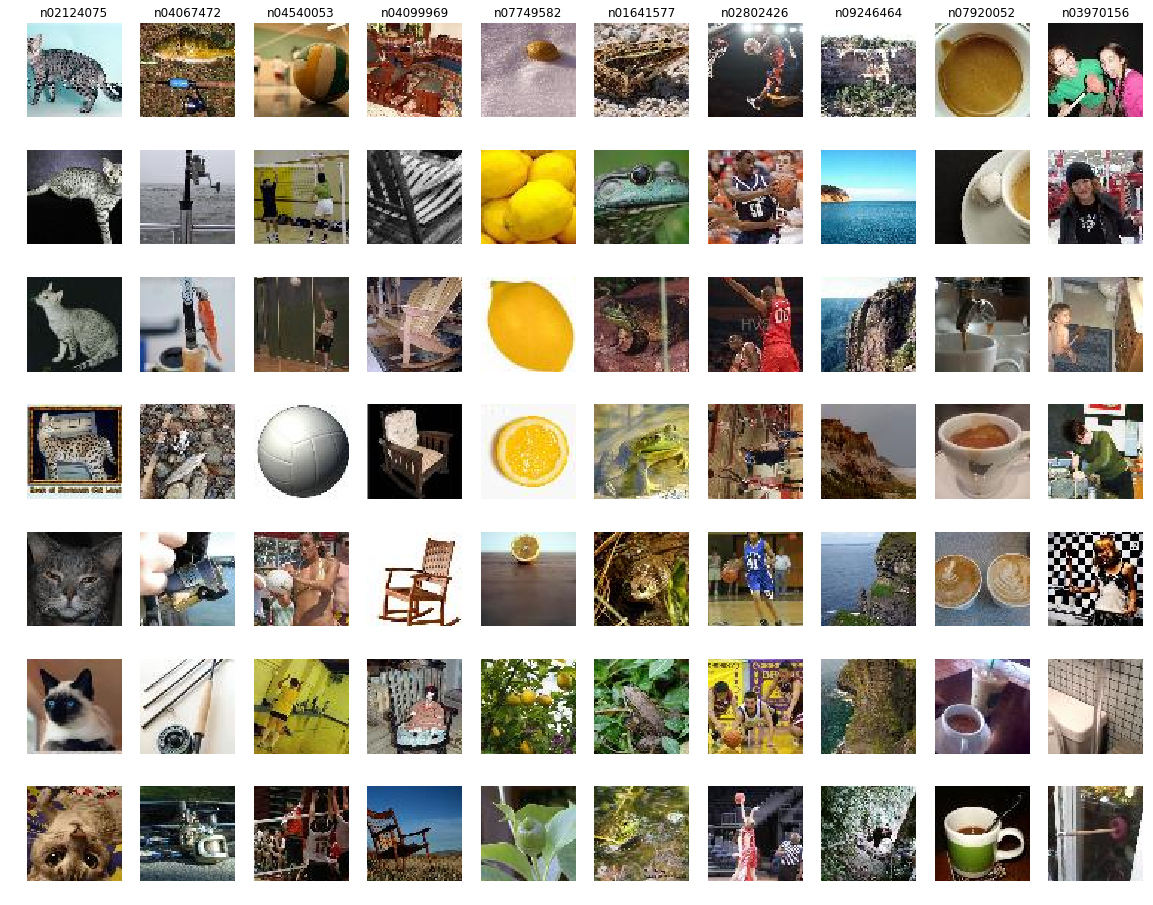

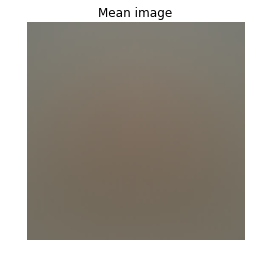

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ids[0:10];
num_classes = len(classes);
samples_per_class = 7;
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow((128*X_train[idx] + meanImage).astype('uint8'), interpolation="nearest")
        plt.axis('off')
        if i == 0:
            plt.title(cls)

# mean image
plt.figure(figsize = (5,4));
plt.imshow(meanImage.astype('uint8'), interpolation="nearest")
plt.title('Mean image')
plt.axis('off')

## Load validation data

In [4]:
def load_validation_data(ids, meanImage):
    filename = [];
    category = [];
    with open("tiny-imagenet-200/val/val_annotations.txt", 'r') as file:
        reader = csv.reader(file, delimiter='\t')
        for row in reader:
            filename.append(row[0]);
            category.append(row[1]);
            
    path = 'tiny-imagenet-200/val/images/';
    X_val = [];
    y_val = [];
    for f, i in zip(filename, category):
        imgObj = Image.open(path+f);
        imgObj.load();
        imgArray = np.asarray(imgObj, dtype="uint8");
        if imgArray.shape != (64, 64, 3):
            h, w = imgArray.shape;
            a = np.empty((h, w, 3), dtype="uint8")
            a[:, :, :] = imgArray[:, :, np.newaxis];
            imgArray = a;   
            
        X_val.append(imgArray); 
        y_val.append(ids.index(i));
        
    X_val = np.array(X_val, dtype="float64");
    y_val = np.array(y_val, dtype="uint8");
    X_val -= meanImage;
    X_val /= 128; # normalize 
    print("X_val shape:", X_val.shape)
    print("y_val shape:", y_val.shape)
    
    return X_val, y_val

# Load data
X_val, y_val = load_validation_data(ids, meanImage);

X_val shape: (10000, 64, 64, 3)
y_val shape: (10000,)


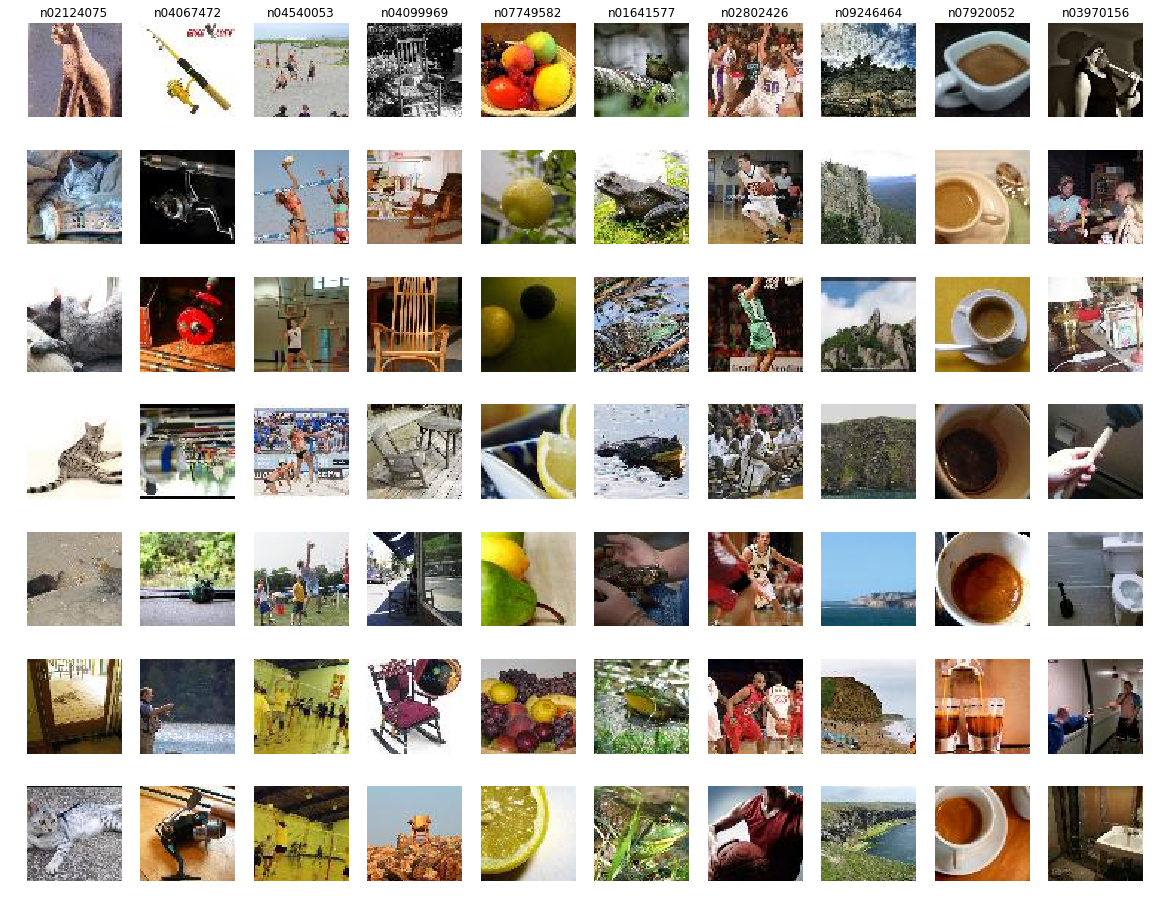

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
plt.figure();
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_val == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow((128*X_val[idx] + meanImage).astype('uint8'), interpolation="nearest")
        plt.axis('off')
        if i == 0:
            plt.title(cls)


## Load test data

In [6]:
def load_test_data(meanImage):    
    path = 'tiny-imagenet-200/test/images/';
    files = [f for f in listdir(path) if ".JPEG" in f]
    
    X_test = [];
    for f in files:
        imgObj = Image.open(path+f);
        imgObj.load();
        imgArray = np.asarray(imgObj, dtype="uint8");
        if imgArray.shape != (64, 64, 3):
            h, w = imgArray.shape;
            a = np.empty((h, w, 3), dtype="uint8")
            a[:, :, :] = imgArray[:, :, np.newaxis];
            imgArray = a;   
            
        X_test.append(imgArray); 
        
    X_test = np.array(X_val, dtype="float64");
    X_test -= meanImage;
    X_test /= 128; # normalize 
    print("X_test shape:", X_test.shape)
    
    return X_val, files

# Load data
X_test, test_files = load_test_data(meanImage);

X_test shape: (10000, 64, 64, 3)


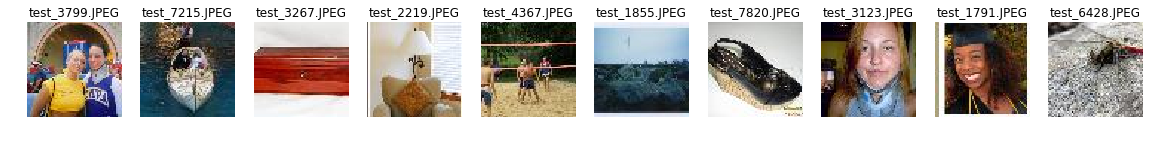

In [7]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
plt.figure();
num_samples = 10;
idxs = np.random.choice(range(len(test_files)), num_samples, replace=False)
for i, idx in enumerate(idxs):
    plt.subplot(1, num_samples, i+1)
    plt.imshow((128*X_test[idx] + meanImage).astype('uint8'), interpolation="nearest")
    plt.axis('off')
    plt.title(test_files[idx])


In [ ]:
# From https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
def VGG_16():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1), activation='relu', input_shape=(64, 64, 3), data_format='channels_last'))
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1), activation='relu', data_format='channels_last'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(128, (3, 3), padding='valid', strides=(1, 1), activation='relu', data_format='channels_last'))
    model.add(Conv2D(128, (3, 3), padding='valid', strides=(1, 1), activation='relu', data_format='channels_last'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(256, (3, 3), padding='valid', strides=(1, 1), activation='relu', data_format='channels_last'))
    model.add(Conv2D(256, (3, 3), padding='valid', strides=(1, 1), activation='relu', data_format='channels_last'))
    model.add(Conv2D(256, (3, 3), padding='valid', strides=(1, 1), activation='relu', data_format='channels_last'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(200, activation='softmax'))

    return model

model = VGG_16();

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

print(y_val.shape)
y_val_categorical = np_utils.to_categorical(y_val, num_classes=200);

model.fit(X_val, y_val_categorical, batch_size=100, epochs=10, verbose=True)
model.evaluate(X_val, y_val, verbose=True)


(10000,)
Epoch 1/10
 2500/10000 [======>.......................] - ETA: 282s - loss: 5.2988

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

In [ ]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [ ]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y, is_training):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 1024])
    b1 = tf.get_variable("b1", shape=[1024])
    W2 = tf.get_variable("W2", shape=[1024, 10])
    b2 = tf.get_variable("b2", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h2 = tf.contrib.layers.batch_norm(h1, decay=0.9, data_format='NHWC', is_training=is_training);
    h3 = tf.nn.max_pool(h2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', data_format='NHWC')
    h3_flat = tf.reshape(h3,[-1,5408])
    h4 = tf.matmul(h3_flat,W1) + b1
    h5 = tf.nn.relu(h4)
    y_out = tf.matmul(h5,W2) + b2
    return y_out

y_out = complex_model(X,y, is_training);


To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [ ]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [ ]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [ ]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = None
optimizer = None

# define our loss
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.RMSPropOptimizer(1e-3) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)


In [ ]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 1.8 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [ ]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 1.5 with an accuracy of 0.45 to 0.55.

In [ ]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for making how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [ ]:
# Feel free to play with this cell

def my_model(X,y,is_training):
    # define our weights (e.g. init_two_layer_convnet)      
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[5, 5, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[6272, 1024]) # 5408
    b1 = tf.get_variable("b1", shape=[1024])
    W2 = tf.get_variable("W2", shape=[1024, 1024]) # 5408
    b2 = tf.get_variable("b2", shape=[1024])
    W3 = tf.get_variable("W3", shape=[1024, 10])
    b3 = tf.get_variable("b3", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h2 = tf.contrib.layers.batch_norm(h1, decay=0.9, data_format='NHWC', is_training=is_training);
    h3 = tf.nn.max_pool(h2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', data_format='NHWC')
    h3_flat = tf.reshape(h3,[-1,6272])
    h4 = tf.matmul(h3_flat,W1) + b1
    h5 = tf.nn.relu(h4)
    h6 = tf.matmul(h5,W2) + b2
    h7 = tf.nn.relu(h6)
    y_out = tf.matmul(h7,W3) + b3
    return y_out

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
mean_loss = None
optimizer = None

# define our loss
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.RMSPropOptimizer(1e-3) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)


In [ ]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [ ]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

As a starting point, I used the complex model. In the convolutional layer, I reduced the filter size to 5. I also added another fully connected layer. I played with the learning rate, number of filters, stride in the convolutional layer, but these changes were less effective. 

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [ ]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.